In [26]:
# %pip install scikit-learn

In [11]:
import torch
import tenseal as ts
import pandas as pd
import random
from time import time
from sklearn.preprocessing import StandardScaler

import numpy as np
import matplotlib.pyplot as plt


from sklearn import datasets
from sklearn.model_selection import train_test_split


torch.random.manual_seed(73)
random.seed(73)
np.random.seed(73)

In [19]:
from sklearn.datasets import load_breast_cancer

breast_cancer = load_breast_cancer()
X, y_np = breast_cancer.data, breast_cancer.target

# The rest of your code can remain the same
X_train_np, X_test_np, y_train_np, y_test_np = train_test_split(
    X, y_np, test_size=0.33, random_state=42
)

x_train_raw = torch.tensor(X_train_np, dtype=torch.float32)
y_train = torch.tensor(y_train_np, dtype=torch.float32).unsqueeze(1)
x_test_raw = torch.tensor(X_test_np, dtype=torch.float32)
y_test = torch.tensor(y_test_np, dtype=torch.float32).unsqueeze(1)


mean = x_train_raw.mean(dim=0)
std = x_train_raw.std(dim=0)

std = torch.where(std == 0, torch.tensor(1.0), std)


x_train = (x_train_raw - mean) / std
x_test = (x_test_raw - mean) / std


print("############# Data summary #############")
print(f"x_train has shape: {x_train.shape}")
print(f"y_train has shape: {y_train.shape}")
print(f"x_test has shape: {x_test.shape}")
print(f"y_test has shape: {y_test.shape}")
print("#######################################")

############# Data summary #############
x_train has shape: torch.Size([381, 30])
y_train has shape: torch.Size([381, 1])
x_test has shape: torch.Size([188, 30])
y_test has shape: torch.Size([188, 1])
#######################################


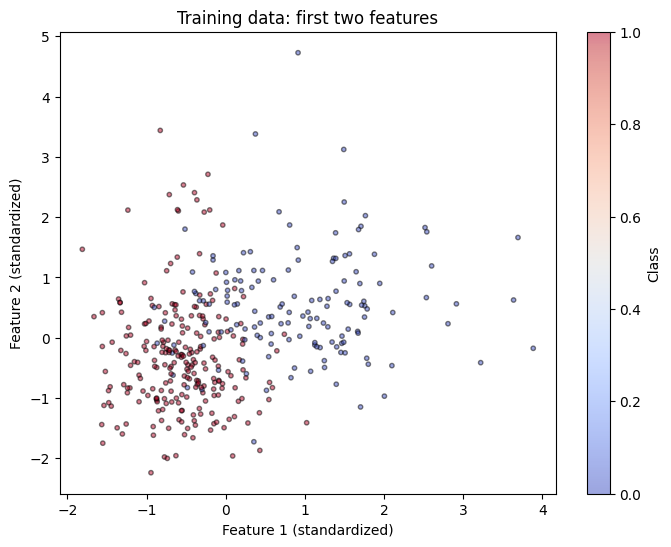

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(
    x_train[:, 0].numpy(),
    x_train[:, 1].numpy(),
    c=y_train.squeeze().numpy(),
    cmap="coolwarm",
    alpha=0.5,
    edgecolor="k",
    s=10,
)
plt.xlabel("Feature 1 (standardized)")
plt.ylabel("Feature 2 (standardized)")
plt.title("Training data: first two features")
plt.colorbar(label="Class")
plt.show()

In [23]:
class LR(torch.nn.Module):
    def __init__(self, n_features):
        super(LR, self).__init__()
        self.lr = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        out = torch.sigmoid(self.lr(x))
        return out


n_features = x_train.shape[1]
model = LR(n_features)
optim = torch.optim.SGD(model.parameters(), lr=1)
criterion = torch.nn.BCELoss()

EPOCHS = 5


def train(model, optim, criterion, x, y, epochs=EPOCHS):
    for e in range(1, epochs + 1):
        optim.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optim.step()
        print(f"Loss at epoch {e}: {loss.data}")
    return model


print("Training plain logistic regression model...")
model = train(model, optim, criterion, x_train, y_train)


def accuracy(model, x, y):
    out = model(x)
    correct = torch.abs(y - out) < 0.5
    return correct.float().mean()


plain_accuracy = accuracy(model, x_test, y_test)
print(f"\nAccuracy on plain test_set: {plain_accuracy}")

Training plain logistic regression model...
Loss at epoch 1: 0.4181373715400696
Loss at epoch 2: 0.19273680448532104
Loss at epoch 3: 0.16130675375461578
Loss at epoch 4: 0.14362820982933044
Loss at epoch 5: 0.13214105367660522

Accuracy on plain test_set: 0.978723406791687


In [24]:
class EncryptedLR_eval:
    def __init__(self, torch_lr):
        self.weight = torch_lr.lr.weight.data.tolist()[0]
        self.bias = torch_lr.lr.bias.data.tolist()

    def forward(self, enc_x):
        enc_out = enc_x.dot(self.weight) + self.bias
        return enc_out

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

    def encrypt(self, context):
        self.weight = ts.ckks_vector(context, self.weight)
        self.bias = ts.ckks_vector(context, self.bias)

    def decrypt(self, context):
        self.weight = self.weight.decrypt()
        self.bias = self.bias.decrypt()


eelr_eval = EncryptedLR_eval(model)


poly_mod_degree_eval = 4096
coeff_mod_bit_sizes_eval = [40, 20, 40]
ctx_eval = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_mod_degree_eval,
    -1,
    coeff_mod_bit_sizes_eval,
)
ctx_eval.global_scale = 2**20
ctx_eval.generate_galois_keys()

print("\nEncrypting test set for evaluation...")
t_start = time()

enc_x_test = [ts.ckks_vector(ctx_eval, x_row.tolist()) for x_row in x_test]
t_end = time()
print(f"Encryption of the test-set took {int(t_end - t_start)} seconds")


def encrypted_evaluation(model_enc_eval, enc_x_test_data, y_test_data):
    t_start = time()
    correct = 0
    for enc_x, y_val in zip(enc_x_test_data, y_test_data):
        enc_out = model_enc_eval(enc_x)
        out_plain = enc_out.decrypt()
        out_val = out_plain[0] if isinstance(out_plain, list) else out_plain
        out_tensor = torch.tensor([out_val])
        pred = torch.sigmoid(out_tensor)
        if torch.abs(pred - y_val) < 0.5:
            correct += 1

    t_end = time()
    eval_time = int(t_end - t_start)
    num_entries = len(y_test_data)
    acc = correct / num_entries
    print(f"Evaluated test_set of {num_entries} entries in {eval_time} seconds")
    print(f"Encrypted evaluation accuracy: {correct}/{num_entries} = {acc}")
    return acc


print("\nPerforming encrypted evaluation...")
encrypted_accuracy_eval = encrypted_evaluation(eelr_eval, enc_x_test, y_test)
diff_accuracy_eval = plain_accuracy - encrypted_accuracy_eval
print(
    f"Difference between plain and encrypted evaluation accuracies: {diff_accuracy_eval}"
)
if diff_accuracy_eval < 0:
    print("Encrypted evaluation accuracy is higher!")


Encrypting test set for evaluation...
Encryption of the test-set took 0 seconds

Performing encrypted evaluation...
Evaluated test_set of 188 entries in 1 seconds
Encrypted evaluation accuracy: 167/188 = 0.8882978723404256
Difference between plain and encrypted evaluation accuracies: 0.09042555093765259


TenSEAL’s CKKSVector (and many FHE libs) maintain C++ internal state and are NOT thread-safe.
So any parallel approach using shared memory (threads) risks crashes or corruption.
And pickling to spawn processes isn’t possible because these objects can’t be serialized.

The solution is to use process-based parallelism with independent contexts per worker
Each worker process initializes its own TenSEAL context and vectors inside the worker.
This means passing raw data (plaintext numpy arrays) to workers, then inside the worker encrypting with its local context before evaluation.
This avoids sharing CKKSVector objects across processes or threads.


There is a limitation on IPython (read as Jupyter Notebook) not fully supporting multiprocessing.

```python
AttributeError: Can't get attribute 'starfield_solve' on <module '__main__' (built-in)>
```

That's why we chould create a .py file in the directory that holds functions which are used in the job



--- Run 1 ---
Sequential encryption...
Sequential encryption time: 0.90s
Parallel encryption...
Parallel encryption time: 4.72s
Sequential evaluation...
Sequential evaluation time: 1.98s
Sequential accuracy: 0.9734
Parallel evaluation...
Parallel evaluation time: 7.73s
Parallel accuracy: 0.9734

Comparison:
Speedup: 0.2x
Accuracy difference: 0.0000

--- Run 2 ---
Sequential encryption...
Sequential encryption time: 1.00s
Parallel encryption...
Parallel encryption time: 7.50s
Sequential evaluation...
Sequential evaluation time: 2.08s
Sequential accuracy: 0.9521
Parallel evaluation...
Parallel evaluation time: 7.92s
Parallel accuracy: 0.9521

Comparison:
Speedup: 0.2x
Accuracy difference: 0.0000

--- Run 3 ---
Sequential encryption...
Sequential encryption time: 1.28s
Parallel encryption...
Parallel encryption time: 9.23s
Sequential evaluation...
Sequential evaluation time: 2.62s
Sequential accuracy: 0.9787
Parallel evaluation...
Parallel evaluation time: 10.48s
Parallel accuracy: 0.978

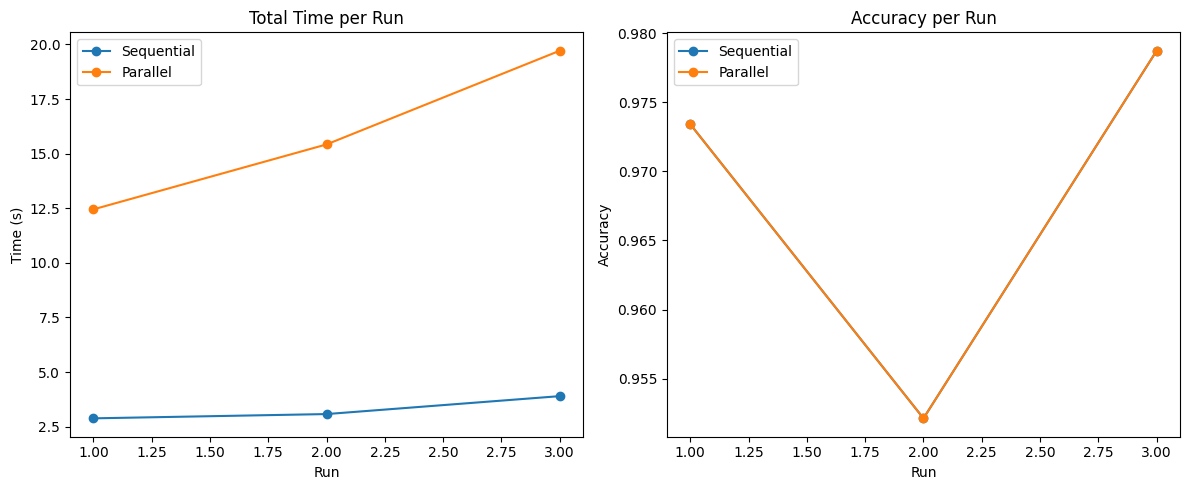

In [25]:
import matplotlib.pyplot as plt

from multiprocessing import Pool, set_start_method
from encrypted import encrypt_chunk, evaluate_chunk

set_start_method("spawn", force=True)

num_procs = 4
num_runs = 3

par_times = []
seq_times = []
par_accs = []
seq_accs = []

for run in range(num_runs):
    print(f"\n--- Run {run+1} ---")

    # 1. Context setup
    poly_mod_degree = 4096
    coeff_mod_bit_sizes = [40, 20, 40]
    ctx = ts.context(ts.SCHEME_TYPE.CKKS, poly_mod_degree, -1, coeff_mod_bit_sizes)
    ctx.global_scale = 2**20
    ctx.generate_galois_keys()

    # 2. Model setup
    eelr = EncryptedLR_eval(model)
    eelr.encrypt(ctx)

    # 3. Serialization
    ctx_serialized = ctx.serialize()
    weight_serialized = eelr.weight.serialize()
    bias_serialized = eelr.bias.serialize()

    # 4. Data preparation
    x_test_np = x_test.numpy()
    y_test_np = y_test.numpy().reshape(-1)

    # --- Sequential encryption ---
    print("Sequential encryption...")
    t0 = time()
    enc_x_test_seq = [
        ts.ckks_vector(ctx, row.tolist()).serialize() for row in x_test_np
    ]
    seq_enc_time = time() - t0
    print(f"Sequential encryption time: {seq_enc_time:.2f}s")

    # --- Parallel encryption ---
    x_chunks = np.array_split(x_test_np, num_procs)
    print("Parallel encryption...")
    t0 = time()
    with Pool(num_procs) as pool:
        encrypted_chunks = pool.map(
            encrypt_chunk, [(ctx_serialized, chunk) for chunk in x_chunks]
        )
    enc_x_test_par = [vec for chunk in encrypted_chunks for vec in chunk]
    par_enc_time = time() - t0
    print(f"Parallel encryption time: {par_enc_time:.2f}s")

    # --- Sequential evaluation ---
    print("Sequential evaluation...")

    def sequential_eval():
        correct = 0
        for x_ser, y in zip(enc_x_test_seq, y_test_np):
            enc_x = ts.ckks_vector_from(ctx, x_ser)
            out = enc_x.dot(eelr.weight) + eelr.bias
            pred = torch.sigmoid(torch.tensor([out.decrypt()]))  # type: ignore
            correct += (torch.abs(pred - y) < 0.5).item()
        return correct / len(y_test_np)

    t0 = time()
    seq_acc = sequential_eval()
    seq_eval_time = time() - t0
    print(f"Sequential evaluation time: {seq_eval_time:.2f}s")
    print(f"Sequential accuracy: {seq_acc:.4f}")

    # --- Parallel evaluation ---
    enc_x_chunks = np.array_split(enc_x_test_par, num_procs)
    y_chunks = np.array_split(y_test_np, num_procs)
    print("Parallel evaluation...")
    t0 = time()
    with Pool(num_procs) as pool:
        results = pool.map(
            evaluate_chunk,
            [
                (ctx_serialized, weight_serialized, bias_serialized, ex, ey)
                for ex, ey in zip(enc_x_chunks, y_chunks)
            ],
        )
    all_outputs = []
    all_labels = []
    for outs, labels in results:
        all_outputs.extend(outs)
        all_labels.extend(labels)
    correct = 0
    for out_ser, y in zip(all_outputs, all_labels):
        out = ts.ckks_vector_from(ctx, out_ser)
        out_val = out.decrypt()[0]
        pred = torch.sigmoid(torch.tensor([out_val]))
        correct += (torch.abs(pred - y) < 0.5).item()
    par_acc = correct / len(all_labels)
    par_eval_time = time() - t0
    print(f"Parallel evaluation time: {par_eval_time:.2f}s")
    print(f"Parallel accuracy: {par_acc:.4f}")

    # Store results
    seq_times.append(seq_enc_time + seq_eval_time)
    par_times.append(par_enc_time + par_eval_time)
    seq_accs.append(seq_acc)
    par_accs.append(par_acc)

    # 8. Results comparison
    print("\nComparison:")
    print(f"Speedup: {abs(seq_times[-1]/par_times[-1]):.1f}x")
    print(f"Accuracy difference: {abs(seq_acc - par_acc):.4f}")

# --- Plotting ---
runs = np.arange(1, num_runs + 1)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(runs, seq_times, marker="o", label="Sequential")
plt.plot(runs, par_times, marker="o", label="Parallel")
plt.title("Total Time per Run")
plt.xlabel("Run")
plt.ylabel("Time (s)")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(runs, seq_accs, marker="o", label="Sequential")
plt.plot(runs, par_accs, marker="o", label="Parallel")
plt.title("Accuracy per Run")
plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()